In [19]:
%run utils.ipynb 
%run models.ipynb

from sklearn.model_selection import cross_validate
import scikitplot as skplt


In [65]:
df = pd.read_csv('../data/clean_union_fe_c2_04_28_20_21_00.csv')
df.shape

(13143, 12)

In [66]:
len(df.name.unique())

15

In [3]:
df.sample(5)

,name,device_type,box_id,false_character,hold_for,key_pressed,long_pressed_equivalent,platform,pressed_after,type_combination,effort,speed
4114,Alper,Computer/Laptop,#text-area-1,ff,176,j,2,Win32,996,ol,896,0.1028
7439,Varun Sapre,Computer/Laptop,#text-area-1,ff,201,et,2,Win32,159,ll,345,0.1042
5395,Dharti,Computer/Laptop,#text-area-1,ff,185,u,2,MacIntel,206,ol,375,0.4474
6046,Shalom,Computer/Laptop,#text-area-1,tt,151,yt,2,MacIntel,290,ll,241,0.0556
455,Varun Sapre,Computer/Laptop,#text-area-3,ff,176,e,2,Win32,88,ol,216,1.7250


In [4]:
models = Models(df.copy(), 0.2, False)

** Non-numeric columns encoded
** Unbalanced stratified per class train_test split
(10514, 11) (2629, 11) (10514,) (2629,)


## Random Forest Unbalanced

In [5]:
rf, y_pred = models.RF()
models.accuracy_score(y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Average number of nodes 5772
Average maximum depth 30
hold_for                   0.202076
platform                   0.141181
pressed_after              0.131353
effort                     0.130764
speed                      0.118506
key_pressed                0.105809
device_type                0.074254
box_id                     0.041147
false_character            0.031893
type_combination           0.023018
long_pressed_equivalent    0.000000
dtype: float64


0.71

In [6]:
print(models.classification_report(y_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       129
           1       0.76      0.87      0.81       190
           2       0.65      0.86      0.74       125
           3       0.63      0.86      0.73       242
           4       0.67      0.72      0.69       165
           5       0.56      0.29      0.38       132
           6       0.62      0.46      0.53       131
           7       0.44      0.37      0.40       145
           8       0.61      0.46      0.52       123
           9       1.00      1.00      1.00       322
          10       0.68      0.57      0.62       190
          11       0.67      0.58      0.62       141
          12       0.78      0.89      0.83       220
          13       0.82      0.86      0.84       217
          14       0.60      0.57      0.58       157

    accuracy                           0.71      2629
   macro avg       0.68      0.67      0.66      2629
weighted avg       0.71   

In [7]:
# Get numerical feature importances
feature_list = models.X_train.columns
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hold_for             Importance: 0.2
Variable: platform             Importance: 0.14
Variable: pressed_after        Importance: 0.13
Variable: effort               Importance: 0.13
Variable: speed                Importance: 0.12
Variable: key_pressed          Importance: 0.11
Variable: device_type          Importance: 0.07
Variable: box_id               Importance: 0.04
Variable: false_character      Importance: 0.03
Variable: type_combination     Importance: 0.02
Variable: long_pressed_equivalent Importance: 0.0


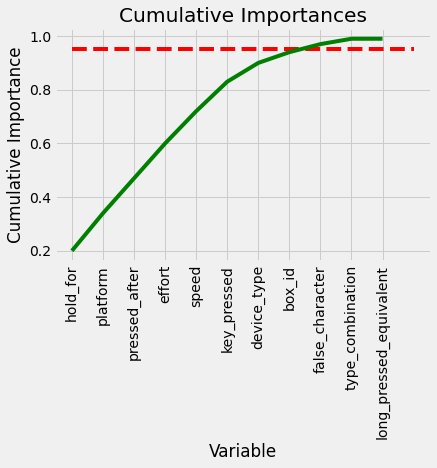

In [69]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

plt.savefig('../images/random_forest_feature_importance.png', bbox_inches='tight')

In [9]:
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 9


In [10]:

# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:9]]
print(important_feature_names)
# Find the columns of the most important features
# important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = models.X_train[important_feature_names]
important_test_features = models.X_test[important_feature_names]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

['hold_for', 'platform', 'pressed_after', 'effort', 'speed', 'key_pressed', 'device_type', 'box_id', 'false_character']
Important train features shape: (10514, 9)
Important test features shape: (2629, 9)


In [11]:
rf.fit(important_train_features, models.y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [12]:
# Make predictions on test data
predictions = rf.predict(important_test_features)

# Performance metrics
errors = abs(predictions - models.y_test)

print('Average absolute error:', round(np.mean(errors), 4), 'degrees.')

# Calculate and display accuracy
accuracy = models.accuracy_score(predictions)
print('Accuracy:', round(accuracy, 2), '%.')


Average absolute error: 1.5002 degrees.
Accuracy: 0.7 %.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


## GridSerach to Get Best HyperParameters

In [13]:
df.sample(5)

,name,device_type,box_id,false_character,hold_for,key_pressed,long_pressed_equivalent,platform,pressed_after,type_combination,effort,speed
82,Varun Sapre,Computer/Laptop,#text-area-1,tt,153,t,2,Win32,279,ol,233,1.0500
475,Varun Sapre,Computer/Laptop,#text-area-3,ff,216,ec,2,Win32,160,ll,336,0.0167
2637,Goddess,Computer/Laptop,#text-area-test,ff,182,h,2,Win32,466,lo,362,0.4000
4469,Nand,Computer/Laptop,#text-area-1,ff,31,te,2,iPhone,260,ll,168,0.1095
9153,Sope Ogundipe,Computer/Laptop,#text-area-3,ff,157,he,2,Win32,125,ll,173,0.1875


In [14]:
final_df, encoded_labels = encode_to_labels(df, [col for col in df.columns if df[col].dtype == 'object'])

In [15]:
final_df.sample(5)

,name,device_type,box_id,false_character,hold_for,key_pressed,long_pressed_equivalent,platform,pressed_after,type_combination,effort,speed
5264,3,0,0,0,198,19,2,0,388,3,496,0.2315
11191,9,0,0,0,41,441,2,2,217,1,210,0.4911
11449,9,0,0,0,50,465,2,2,450,1,217,0.5030
2677,6,1,0,0,37,19,2,2,703,3,631,0.1162
5699,3,0,2,0,240,488,2,0,237,0,367,0.0079


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size=.2, stratify=df.iloc[:,0], random_state=111)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10514, 11) (2629, 11) (10514,) (2629,)


In [17]:
rf = RandomForestClassifier(random_state = 111)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 111,
 'verbose': 0,
 'warm_start': False}


## Random Search with Cross Validation

In [18]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [51]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 111)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=111, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 31.1min finished


In [52]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [63]:

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    accuracy = metrics.accuracy_score(test_labels, predictions)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [64]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred).round(2)

0.68

In [65]:
base_accuracy = evaluate(base_model, X_test, y_test)


Model Performance
Average Error: 1.5862 degrees.
Accuracy = 0.68%.


In [66]:
best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)
y_pred = best_random.predict(X_test)
metrics.accuracy_score(y_test, y_pred).round(2)

0.71

In [67]:
best_random_accuracy = evaluate(best_random, X_test, y_test)


Model Performance
Average Error: 1.3872 degrees.
Accuracy = 0.71%.


In [68]:
print('Improvement of {:0.2f}%.'.format( 100 * (best_random_accuracy - base_accuracy) / base_accuracy))


Improvement of 4.51%.


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 50, 70],
    'max_features': [3, 4],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4],
    'n_estimators': [100, 125, 150]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(X_train, y_train);

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  6.2min finished


In [25]:
grid_search_final.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 125}

In [26]:
best_final = grid_search_final.best_estimator_
best_final.fit(X_train, y_train)
y_pred = best_final.predict(X_test)
metrics.accuracy_score(y_test, y_pred).round(2)

0.71

In [27]:

model = best_final
cv = cross_validate(model, X_train, y_train, cv=5)
print(cv['test_score'].round(2))
print(cv['test_score'].mean())

[0.66 0.68 0.67 0.66 0.67]
0.6679665178601726


In [28]:
cv['test_score'].shape[0]

5

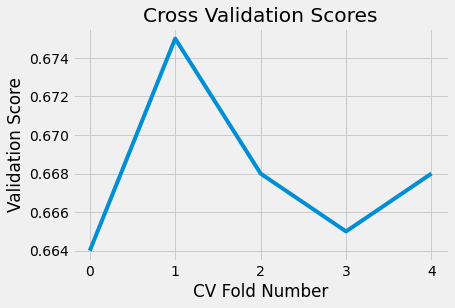

In [67]:
sns.lineplot(x=range(cv['test_score'].shape[0]), y=cv['test_score'].round(3))
plt.xlabel('CV Fold Number')
plt.ylabel('Validation Score')
plt.title('Cross Validation Scores')
plt.savefig('../images/random_forest_cv_scores.png', bbox_inches='tight')
plt.show()

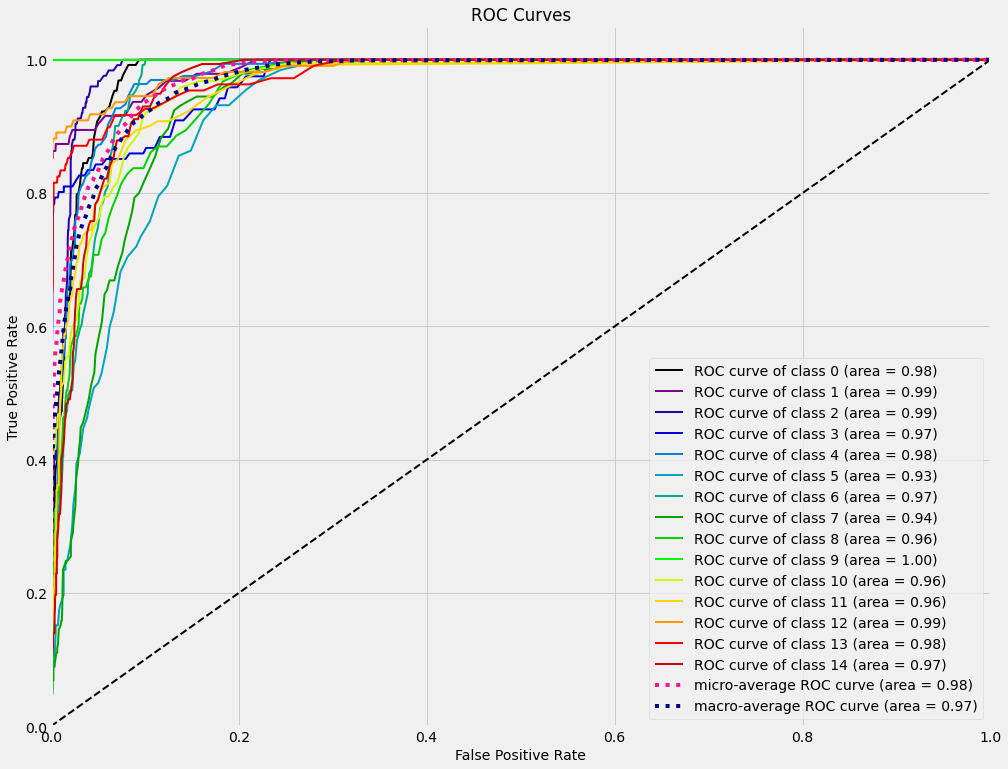

In [68]:
y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas,figsize=(15,12))
plt.savefig('../images/random_forest_roc.png', bbox_inches='tight')
plt.show()

In [128]:
list(zip(y_probas, y_true))

[(array([0.   , 0.   , 0.   , 0.024, 0.   , 0.   , 0.   , 0.008, 0.056,
         0.   , 0.888, 0.   , 0.016, 0.008, 0.   ]), 10),
 (array([0.   , 0.072, 0.   , 0.   , 0.072, 0.168, 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.032, 0.552, 0.104, 0.   ]), 13),
 (array([0.688, 0.   , 0.048, 0.   , 0.   , 0.   , 0.264, 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]), 6),
 (array([0.   , 0.   , 0.   , 0.8  , 0.   , 0.   , 0.   , 0.08 , 0.064,
         0.   , 0.056, 0.   , 0.   , 0.   , 0.   ]), 3),
 (array([0.576, 0.   , 0.016, 0.   , 0.   , 0.   , 0.408, 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]), 0),
 (array([0.   , 0.   , 0.   , 0.312, 0.   , 0.   , 0.   , 0.08 , 0.04 ,
         0.   , 0.36 , 0.   , 0.   , 0.   , 0.208]), 3),
 (array([0.   , 0.12 , 0.   , 0.016, 0.528, 0.112, 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.016, 0.032, 0.176, 0.   ]), 4),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 9),
 (array([0.   , 0.12

In [35]:
cf_matrix = metrics.confusion_matrix(y_test, model.predict(X_test))

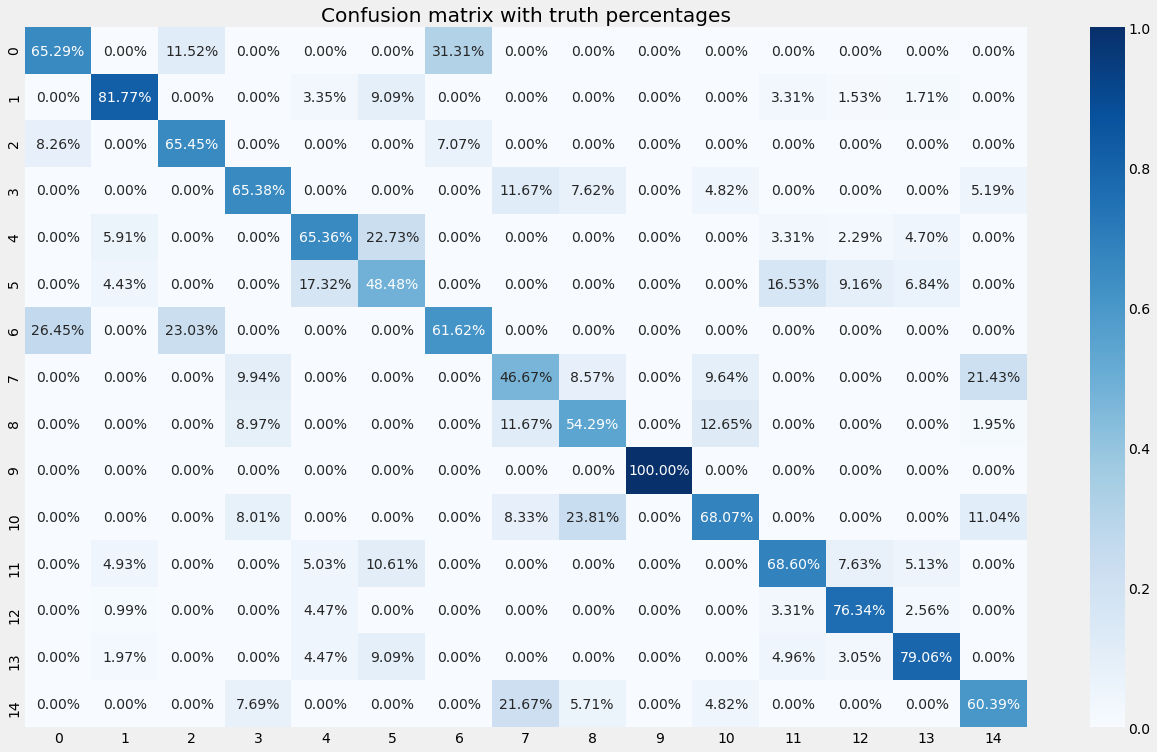

In [64]:
plt.figure(figsize=(20,12))
sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=0), annot=True, 
            fmt='.2%', cmap='Blues')
plt.title('Confusion matrix with truth percentages')
plt.savefig('../images/random_forest_confusion_matrix.png')
plt.show()

In [62]:
(y_test.value_counts(normalize=True)*100).sort_index()

0      4.906809
1      7.227083
2      4.754660
3      9.205021
4      6.276151
5      5.020921
6      4.982883
7      5.515405
8      4.678585
9     12.248003
10     7.227083
11     5.363256
12     8.368201
13     8.254089
14     5.971852
Name: name, dtype: float64